# Chinook Music Store Exploration

I'll be working with a modified version of a database called Chinook. The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. 

![img](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)
- Tables names are shown in bold, with the columns in each table listed below.
- Each table has one or more columns with shading, which indicates those columns are a primary key.
- Relationships between tables are shown using lines between the tables. 
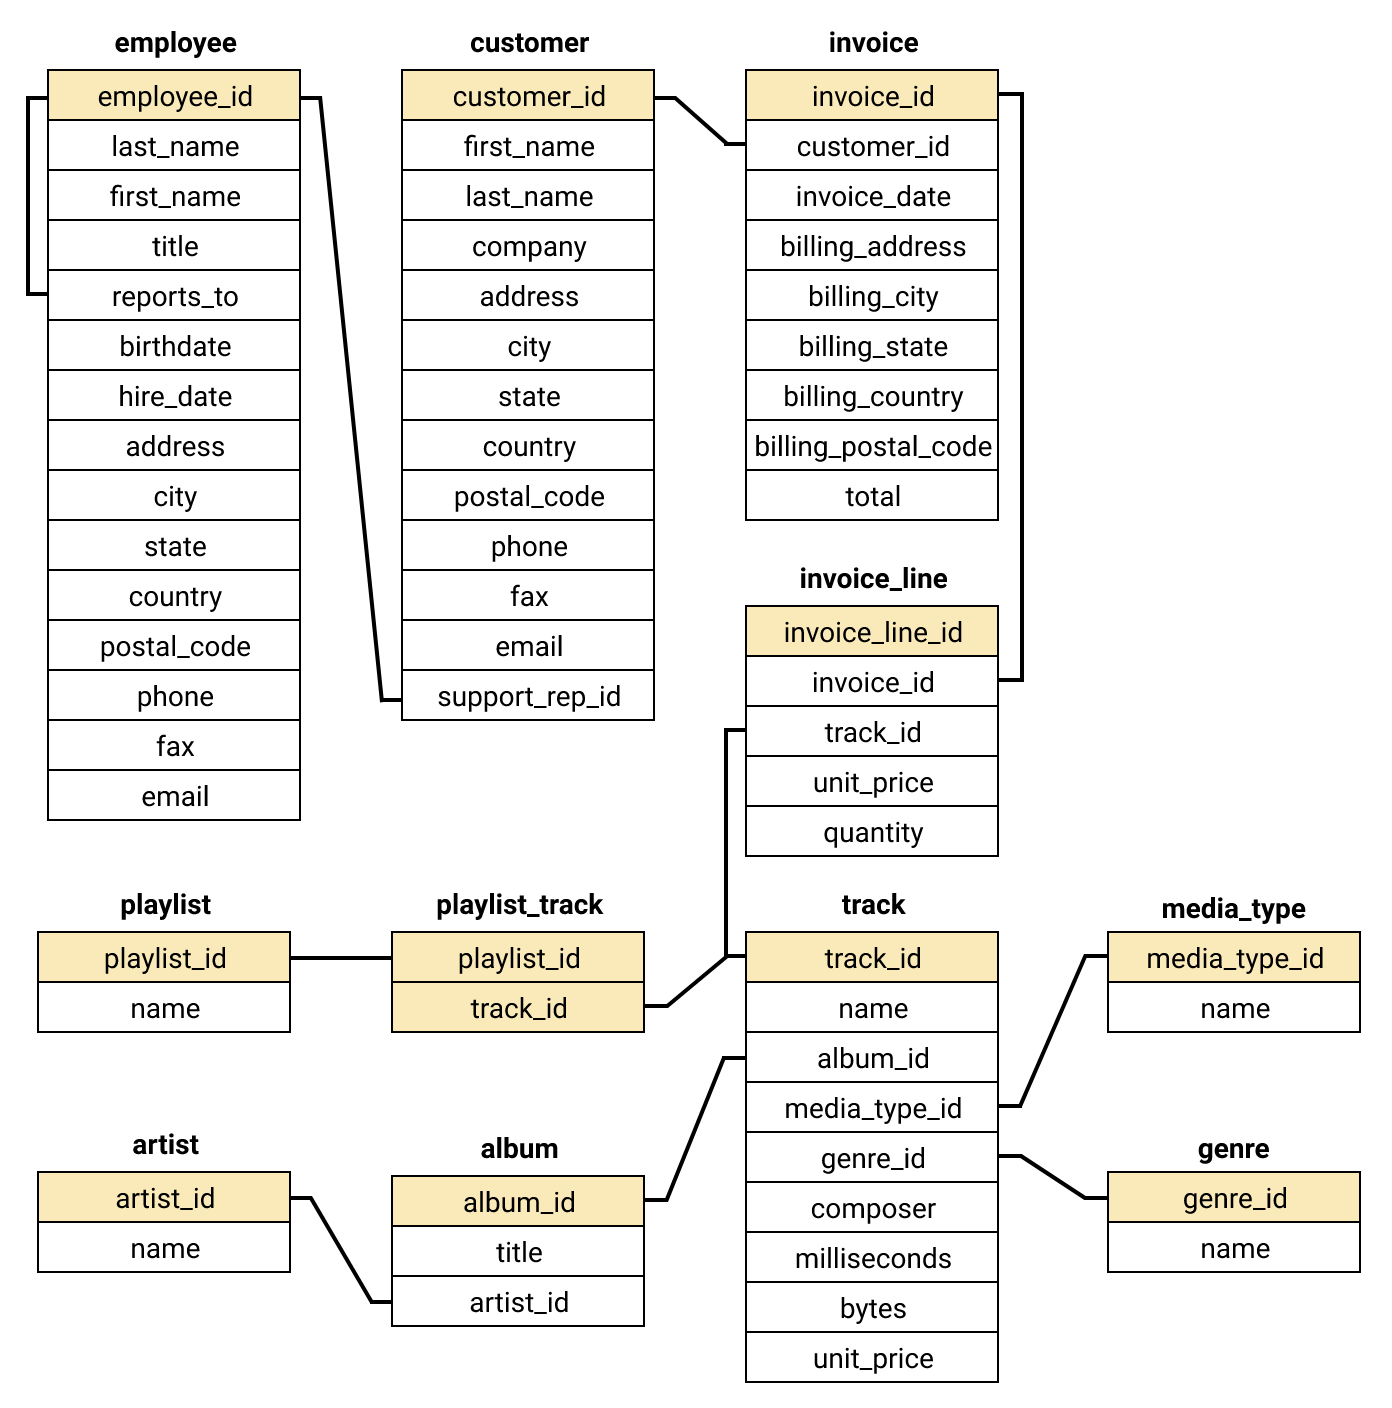

In [19]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("chinook.db")
cursor = conn.cursor()

## Exploration

For one single purchase (invoice_id) we want to know, for each track purchased:

- The id of the track.
- The name of the track.
- The name of media type of the track.
- The price that the customer paid for the track.
- The quantity of the track that was purchased.

View track table:

In [20]:
q = "SELECT * FROM track LIMIT 5"
pd.read_sql_query(q,conn)

,track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99


View invoice_line table:

In [21]:
q = "SELECT * FROM invoice_line LIMIT 5"
pd.read_sql_query(q,conn)

,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,1,1,1158,0.99,1
1,2,1,1159,0.99,1
2,3,1,1160,0.99,1
3,4,1,1161,0.99,1
4,5,1,1162,0.99,1


View media_type table:

In [22]:
q = "SELECT * FROM invoice_line LIMIT 5"
pd.read_sql_query(q,conn)

,media_type_id,name
0,1,MPEG audio file
1,2,Protected AAC audio file
2,3,Protected MPEG-4 video file
3,4,Purchased AAC audio file
4,5,AAC audio file


### Query that gathers data about the invoice with an invoice_id of 4.

In [23]:
q = """
SELECT  t.track_id, 
        t.name AS track_name,
        m.name AS track_type,
        i.unit_price,
        i.quantity
FROM invoice_line AS i
INNER JOIN track AS t
ON i.track_id = t.track_id
INNER JOIN media_type AS m
ON t.media_type_id = m.media_type_id
WHERE i.invoice_id = 4;
"""

pd.read_sql_query(q,conn)

,track_id,track_name,track_type,unit_price,quantity
0,3448,"Lamentations of Jeremiah, First Set \ Incipit ...",Protected AAC audio file,0.99,1
1,2560,Violent Pornography,MPEG audio file,0.99,1
2,3336,War Pigs,Purchased AAC audio file,0.99,1
3,829,Let's Get Rocked,MPEG audio file,0.99,1
4,1872,Attitude,MPEG audio file,0.99,1
5,748,Dealer,MPEG audio file,0.99,1
6,1778,You're What's Happening (In The World Today),MPEG audio file,0.99,1
7,2514,Spoonman,MPEG audio file,0.99,1


### Connect 2 more together to get artist information with track through album, but don't use any album columns

In this case, we will need to join two new tables to our existing query:

- artist, which contains the artist name data that we need
- album, which has a column common to each of the artist and track tables which allows us to join those two tables.

In [24]:
q = """
SELECT  t.track_id, 
        t.name AS track_name,
        ar.name AS artist_name,
        m.name AS track_type,
        i.unit_price,
        i.quantity
FROM invoice_line AS i
INNER JOIN track AS t
ON i.track_id = t.track_id
INNER JOIN media_type AS m
ON t.media_type_id = m.media_type_id
INNER JOIN album AS al
ON t.album_id = al.album_id
INNER JOIN artist AS ar
ON ar.artist_id = al.artist_id
WHERE i.invoice_id = 4;
"""

pd.read_sql_query(q,conn)

,track_id,track_name,artist_name,track_type,unit_price,quantity
0,3448,"Lamentations of Jeremiah, First Set \ Incipit ...",The King's Singers,Protected AAC audio file,0.99,1
1,2560,Violent Pornography,System Of A Down,MPEG audio file,0.99,1
2,3336,War Pigs,Cake,Purchased AAC audio file,0.99,1
3,829,Let's Get Rocked,Def Leppard,MPEG audio file,0.99,1
4,1872,Attitude,Metallica,MPEG audio file,0.99,1
5,748,Dealer,Deep Purple,MPEG audio file,0.99,1
6,1778,You're What's Happening (In The World Today),Marvin Gaye,MPEG audio file,0.99,1
7,2514,Spoonman,Soundgarden,MPEG audio file,0.99,1


### Query that lists the top 10 artists, calculated by the number of times a track by that artist has been purchased.
Because the invoice_line table contains each individual song from each customer purchase, it contains information about which songs are purchased the most. We can use the table to find out which artists are purchased the most.

I'll break down several queries for one main query:

In [ ]:
SELECT  t.track_id, 
        ar.name AS artist_name
FROM track AS t
INNER JOIN album AS al
ON al.album_id = t.album_id
INNER JOIN artist as ar
ON ar.artist_id = al.artist_id
ORDER 1 LIMIT 5;

Next, I need to join this subquery to our invoice_line table. I'll give our subquery an alias ta for 'track artist' to make it easier to refer to. Again, I'll add an ORDER BY and LIMIT statement to this step so our output is more manageable.

In [ ]:
SELECT
    i.invoice_line_id,
    i.track_id,
    ta.artist_name
FROM invoice_line AS i
INNER JOIN (
        SELECT  t.track_id, 
                ar.name AS artist_name
        FROM track AS t
        INNER JOIN album AS al
        ON al.album_id = t.album_id
        INNER JOIN artist as ar
        ON ar.artist_id = al.artist_id
            ) ta
ON ta.track_id = i.track_id
ORDER 1 LIMIT 5;

All that remains now is to add a GROUP BY clause, remove the extra columns and use ORDER BY and LIMIT clauses to select the 10 most popular artists.

In [27]:
q = """
SELECT
    ta.artist_name artist,
    COUNT(*) tracks_purchased
FROM invoice_line il
INNER JOIN (
            SELECT
                t.track_id,
                ar.name artist_name
            FROM track t
            INNER JOIN album al
            ON al.album_id = t.album_id
            INNER JOIN artist ar
            ON ar.artist_id = al.artist_id
           ) ta
ON ta.track_id = il.track_id
GROUP BY 1
ORDER BY 2 DESC LIMIT 10;
"""

pd.read_sql_query(q,conn)

,artist,tracks_purchased
0,Queen,192
1,Jimi Hendrix,187
2,Nirvana,130
3,Red Hot Chili Peppers,130
4,Pearl Jam,129
5,AC/DC,124
6,Guns N' Roses,124
7,Foo Fighters,121
8,The Rolling Stones,117
9,Metallica,106


### Query that returns the top 5 albums, as calculated by the number of times a track from that album has been purchased. 

In [31]:
q = """
SELECT
    ta.album_title AS album,
    ta.artist_name AS artist,
    COUNT(*) AS tracks_purchased
FROM invoice_line AS il
INNER JOIN (
            SELECT
                t.track_id,
                al.title AS album_title,
                ar.name AS artist_name
            FROM track AS t
            INNER JOIN album al 
            ON al.album_id = t.album_id
            INNER JOIN artist ar
            ON ar.artist_id = al.artist_id
           ) ta
ON ta.track_id = il.track_id
GROUP BY 1, 2
ORDER BY 3 DESC LIMIT 5;
""" 

pd.read_sql_query(q,conn)

,album,artist,tracks_purchased
0,Are You Experienced?,Jimi Hendrix,187
1,Faceless,Godsmack,96
2,Mezmerize,System Of A Down,93
3,Get Born,JET,90
4,The Doors,The Doors,83


## Recursive Joins
We can see that in our employee table, where there is a reports_to column that has a relation to the employee_id column within the same table.

The reports_to column identifies each employee's supervisor. If we wanted to create a report of each employee and their supervisor's name, we would need some way of joining a table to itself. Doing this is called a recursive join.

###  Query that returns information about each employee and their supervisor.

In [33]:
q = """
SELECT e1.first_name || " " || e1.last_name AS employee_name,
       e1.title AS employee_title,
       e2.first_name || " " || e2.last_name AS supervisor_name,
       e2.title AS supervisor_title
FROM employee AS e1
LEFT JOIN employee AS e2
ON e1.reports_to = e2.employee_id
ORDER BY 1;
"""

pd.read_sql_query(q,conn)

,employee_name,employee_title,supervisor_name,supervisor_title
0,Andrew Adams,General Manager,None,None
1,Jane Peacock,Sales Support Agent,Nancy Edwards,Sales Manager
2,Laura Callahan,IT Staff,Michael Mitchell,IT Manager
3,Margaret Park,Sales Support Agent,Nancy Edwards,Sales Manager
4,Michael Mitchell,IT Manager,Andrew Adams,General Manager
5,Nancy Edwards,Sales Manager,Andrew Adams,General Manager
6,Robert King,IT Staff,Michael Mitchell,IT Manager
7,Steve Johnson,Sales Support Agent,Nancy Edwards,Sales Manager


## Like Operator

For example:
- %Jen - will match Jen at the end of a string, eg Sarah-Jen
- Jen% - will match Jen at the start of a string, eg Jenny
- %Jen% - will match Jen anywhere within the string, eg Kris Jenner

### Locate record that is Jen

In [34]:
q = """
SELECT
    first_name,
    last_name,
    phone
FROM customer
WHERE first_name LIKE "%Jen%";
"""

pd.read_sql_query(q,conn)

,first_name,last_name,phone
0,Jennifer,Peterson,+1 (604) 688-2255


## Case Statements

###  Add a new column protected, which indicates whether each media type is protected.

In [35]:
q = """
SELECT
    media_type_id,
    name,
    CASE
        WHEN name LIKE '%Protected%' THEN 1
        ELSE 0
        END
        AS protected
FROM media_type;"""

pd.read_sql_query(q,conn)

,media_type_id,name,protected
0,1,MPEG audio file,0
1,2,Protected AAC audio file,1
2,3,Protected MPEG-4 video file,1
3,4,Purchased AAC audio file,0
4,5,AAC audio file,0


### Query that summarizes the purchases of each customer.

In [36]:
q = """
SELECT 
    c.first_name || " " || c.last_name AS customer_name,
    COUNT(i.invoice_id) AS number_of_purchases,
    SUM(i.total) as total_spent,
    CASE
        WHEN SUM(i.total) < 40 THEN "small spender"
        WHEN SUM(i.total) > 100 THEN "big spender"
        ELSE "regular"
        END
        AS customer_category
FROM customer AS c
INNER JOIN invoice AS i
ON c.customer_id = i.customer_id
GROUP BY 1
ORDER BY 1;
"""

pd.read_sql_query(q,conn)

,customer_name,number_of_purchases,total_spent,customer_category
0,Aaron Mitchell,8,70.29,regular
1,Alexandre Rocha,10,69.30,regular
2,Astrid Gruber,9,69.30,regular
3,Bjørn Hansen,9,72.27,regular
4,Camille Bernard,9,79.20,regular
5,Daan Peeters,7,60.39,regular
6,Dan Miller,12,95.04,regular
7,Diego Gutiérrez,5,39.60,small spender
8,Dominique Lefebvre,9,72.27,regular
9,Eduardo Martins,12,60.39,regular


## WITH Clause

WITH clauses allow you to define one or more named subqueries before the start of the main query. The main query then refers to the subquery by it's alias name, just as if it's a table in the database.

Compare the query below without a WITH clause:

In [ ]:
SELECT * FROM
    (
     SELECT
         t.name,
         ar.name artist,
         al.title album_name,
         mt.name media_type,
         g.name genre,
         t.milliseconds length_milliseconds
     FROM track t
     INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
     INNER JOIN genre g ON g.genre_id = t.genre_id
     INNER JOIN album al ON al.album_id = t.album_id
     INNER JOIN artist ar ON ar.artist_id = al.artist_id
    )
WHERE album_name = "Jagged Little Pill";

Compare the query below with a WITH clause:

In [37]:
q = """
WITH track_info AS
    (                
     SELECT
         t.name,
         ar.name artist,
         al.title album_name,
         mt.name media_type,
         g.name genre,
         t.milliseconds length_milliseconds
     FROM track t
     INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
     INNER JOIN genre g ON g.genre_id = t.genre_id
     INNER JOIN album al ON al.album_id = t.album_id
     INNER JOIN artist ar ON ar.artist_id = al.artist_id
    )

SELECT * FROM track_info
WHERE album_name = "Jagged Little Pill";
"""

pd.read_sql_query(q,conn)

,name,artist,album_name,media_type,genre,length_milliseconds
0,All I Really Want,Alanis Morissette,Jagged Little Pill,MPEG audio file,Rock,284891
1,You Oughta Know,Alanis Morissette,Jagged Little Pill,MPEG audio file,Rock,249234
2,Perfect,Alanis Morissette,Jagged Little Pill,MPEG audio file,Rock,188133
3,Hand In My Pocket,Alanis Morissette,Jagged Little Pill,MPEG audio file,Rock,221570
4,Right Through You,Alanis Morissette,Jagged Little Pill,MPEG audio file,Rock,176117
5,Forgiven,Alanis Morissette,Jagged Little Pill,MPEG audio file,Rock,300355
6,You Learn,Alanis Morissette,Jagged Little Pill,MPEG audio file,Rock,239699
7,Head Over Feet,Alanis Morissette,Jagged Little Pill,MPEG audio file,Rock,267493
8,Mary Jane,Alanis Morissette,Jagged Little Pill,MPEG audio file,Rock,280607
9,Ironic,Alanis Morissette,Jagged Little Pill,MPEG audio file,Rock,229825


### Query that shows summary data for every playlist in the Chinook database

In [39]:
q = """
WITH playlist_info AS
    (
     SELECT
        p.playlist_id as playlist_id,
        p.name as playlist_name,
        t.name as track_name,
        (t.milliseconds/1000) as length_seconds
     FROM playlist AS p
     LEFT JOIN playlist_track as pt
     ON p.playlist_id = pt.playlist_id
     LEFT JOIN track as t
     ON t.track_id = pt.track_id
     )

SELECT
    playlist_id,
    playlist_name,
    COUNT(track_name) AS number_of_tracks,
    SUM(length_seconds) AS length_seconds
FROM playlist_info
GROUP BY 1,2
ORDER BY playlist_id;
"""

pd.read_sql_query(q,conn)

,playlist_id,playlist_name,number_of_tracks,length_seconds
0,1,Music,3290,876049.0
1,2,Movies,0,NaN
2,3,TV Shows,213,500987.0
3,4,Audiobooks,0,NaN
4,5,90’s Music,1477,397970.0
5,6,Audiobooks,0,NaN
6,7,Movies,0,NaN
7,8,Music,3290,876049.0
8,9,Music Videos,1,294.0
9,10,TV Shows,213,500987.0


## Creating View

WITH clauses are temporary so we can use a CREATE VIEW clause to save it for future reference. An easy way to think of this is the WITH clause creates a temporary view.

Syntax for View:

    CREATE VIEW database.view_name AS
        SELECT * FROM database.table;
        
### View of all customers that live in the USA.

In [ ]:
CREATE VIEW chinook.customer_usa AS 
     SELECT * FROM chinook.customer
     WHERE country = "USA";

### Create a second view of customers that have purchased more than $90 from our store.

In [ ]:
CREATE VIEW
    chinook.customer_gt_90_dollars AS
SELECT c.*
FROM chinook.invoice AS i
INNER JOIN chinook.customer AS c
ON i.customer_id = c.customer_id
    GROUP BY 1
    HAVING SUM(i.total) >90;

SELECT * FROM chinook.customer_gt_90_dollars;

## Complex Query

###  Query to find the customer from each country that has spent the most money at our store.

The query you will write will include:

- One or more named subqueries defined in a WITH clause
- Aggregate functions like SUM() and MAX()
- Several INNER JOINs
- A subquery to define a column
- GROUP BY and ORDER BY clauses

In [50]:
q = """
WITH
    customer_country_purchases AS
        (
         SELECT
             i.customer_id,
             c.country,
             SUM(i.total) total_purchases
         FROM invoice i
         INNER JOIN customer c
         ON i.customer_id = c.customer_id
         GROUP BY 1, 2
        ),
    country_max_purchase AS
        (
         SELECT
             country,
             MAX(total_purchases) max_purchase
         FROM customer_country_purchases
         GROUP BY 1
        ),
    country_best_customer AS
        (
         SELECT
            cmp.country,
            cmp.max_purchase,
            (
             SELECT ccp.customer_id
             FROM customer_country_purchases ccp
             WHERE ccp.country = cmp.country 
                AND cmp.max_purchase = ccp.total_purchases
            ) customer_id
         FROM country_max_purchase cmp
        )

SELECT
    cbc.country country,
    c.first_name || " " || c.last_name customer_name,
    cbc.max_purchase total_purchased
FROM customer c
INNER JOIN country_best_customer cbc
ON cbc.customer_id = c.customer_id
ORDER BY 1 ASC
"""

pd.read_sql_query(q,conn)

,country,customer_name,total_purchased
0,Argentina,Diego Gutiérrez,39.60
1,Australia,Mark Taylor,81.18
2,Austria,Astrid Gruber,69.30
3,Belgium,Daan Peeters,60.39
4,Brazil,Luís Gonçalves,108.90
5,Canada,François Tremblay,99.99
6,Chile,Luis Rojas,97.02
7,Czech Republic,František Wichterlová,144.54
8,Denmark,Kara Nielsen,37.62
9,Finland,Terhi Hämäläinen,79.20


In [51]:
conn.close()